In [35]:
# Eng/Amr Mostafa Omar
# Nile University ,Cairo, Egypt
# Data 27/5/2024

In [36]:
import numpy as np
import gym
from gym import spaces
from scipy.linalg import solve
import matplotlib.pyplot as plt
from matplotlib import colors

##**I.**Implement a Gridworld Environment: (Deterministic Env)

In [37]:
class Grid_world_Env_Deterministic(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, grid_size=(5, 5), start=(0, 0), goal=(1, 4), fire_cells=[(0, 2), (3, 3), (4, 1)], blocked_cells=[(1, 1), (1, 2), (2, 1),(2,2)], noise=0):
        super(Grid_world_Env_Deterministic, self).__init__()

        self.grid_size = grid_size
        self.start = start
        self.goal = goal
        self.fire_cells = fire_cells
        self.blocked_cells = blocked_cells
        self.noise = noise
        self.current_position = start

        self.action_space = spaces.Discrete(4)
        # 4 actions: 0=North, 1=East, 2=South, 3=West
        self.observation_space = spaces.Tuple((spaces.Discrete(grid_size[0]), spaces.Discrete(grid_size[1])))

        self.rewards = np.zeros(grid_size)
        self.rewards[goal] = 5
        for cell in fire_cells:
            self.rewards[cell] = -5

    def reset(self):
        self.current_position = self.start
        return self.current_position

    def is_valid_state(self, x, y):
        return 0 <= x < self.grid_size[0] and 0 <= y < self.grid_size[1] and (x, y) not in self.blocked_cells

    def step(self, action):
        if np.random.rand() < self.noise:
            action = np.random.choice([0, 1, 2, 3])

        x, y = self.current_position
        if action == 0:  # North
            new_x, new_y = x - 1, y
        elif action == 1:  # East
            new_x, new_y = x, y + 1
        elif action == 2:  # South
            new_x, new_y = x + 1, y
        elif action == 3:  # West
            new_x, new_y = x, y - 1

        if not self.is_valid_state(new_x, new_y):
            new_x, new_y = x, y

        reward = self.rewards[new_x, new_y]
        done = (new_x, new_y) == self.goal or (new_x, new_y) in self.fire_cells

        self.current_position = (new_x, new_y)

        return (new_x, new_y), reward, done, {}


    def render(self, mode='human'):
        grid_copy = np.full(self.grid_size, -5)  # Initialize grid with  white

        # Mark goal, fire, and blocked cells
        grid_copy[self.goal] = 5
        for cell in self.fire_cells:
            grid_copy[cell] = 3
        for cell in self.blocked_cells:
            grid_copy[cell] = 0

        # Define a color map for the grid
        cmap = colors.ListedColormap(['white', 'black', 'red', 'green'])
        bounds = [-6, -4, 1, 4, 6]
        norm = colors.BoundaryNorm(bounds, cmap.N)

        # Plot the grid
        plt.imshow(grid_copy, cmap=cmap, norm=norm, interpolation='nearest')

        # Mark the agent's position with a different marker
        agent_x, agent_y = self.current_position
        plt.scatter(agent_y, agent_x, c='blue', s=200, marker='*', label='Agent')

        plt.colorbar(ticks=[-5, 0, 3, 5], format='%d')
        plt.legend()
        plt.show()

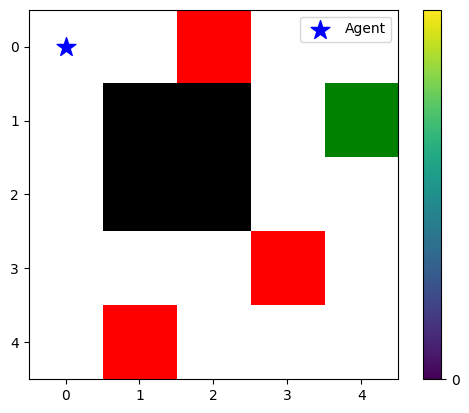

Action: 3, Next State: (0, 0), Reward: 0.0, Done: False


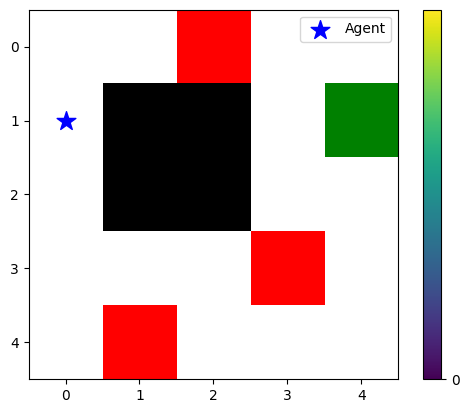

Action: 2, Next State: (1, 0), Reward: 0.0, Done: False


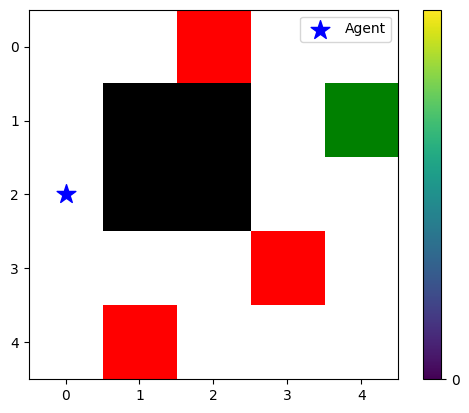

Action: 2, Next State: (2, 0), Reward: 0.0, Done: False


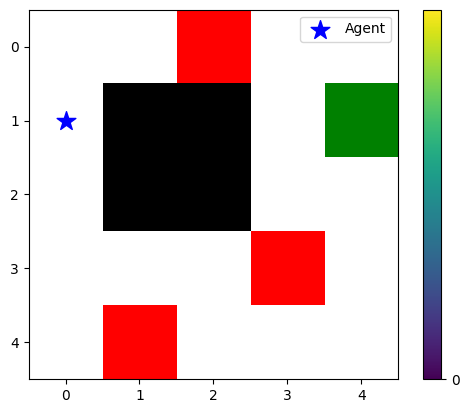

Action: 0, Next State: (1, 0), Reward: 0.0, Done: False


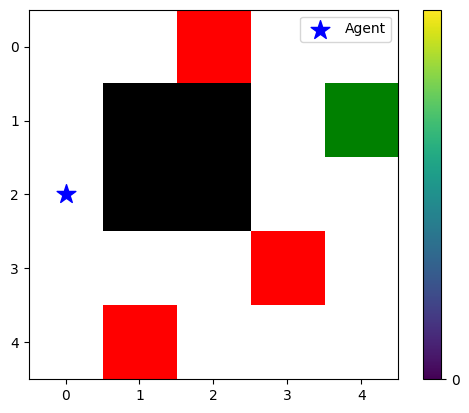

Action: 2, Next State: (2, 0), Reward: 0.0, Done: False


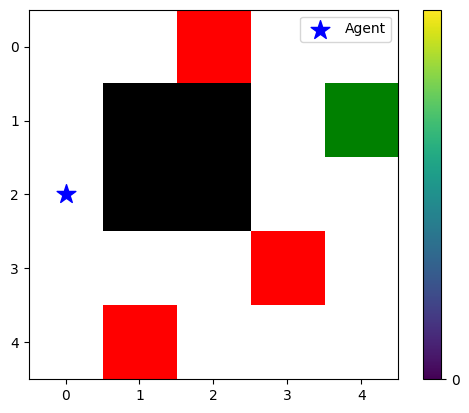

Action: 3, Next State: (2, 0), Reward: 0.0, Done: False


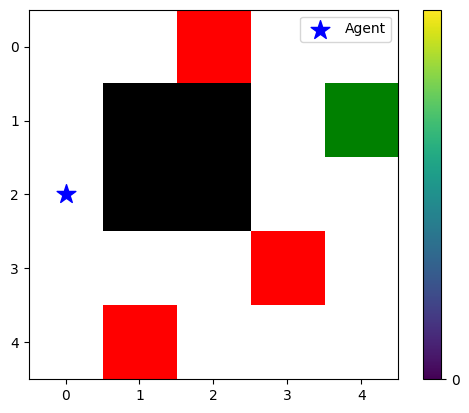

Action: 1, Next State: (2, 0), Reward: 0.0, Done: False


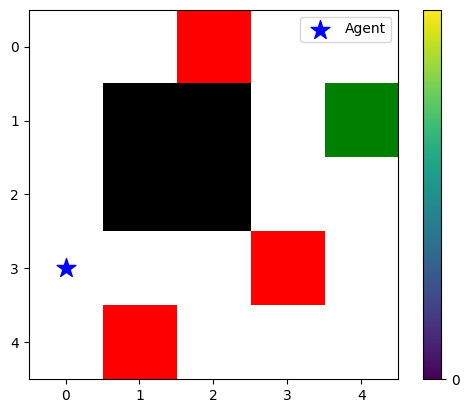

Action: 2, Next State: (3, 0), Reward: 0.0, Done: False


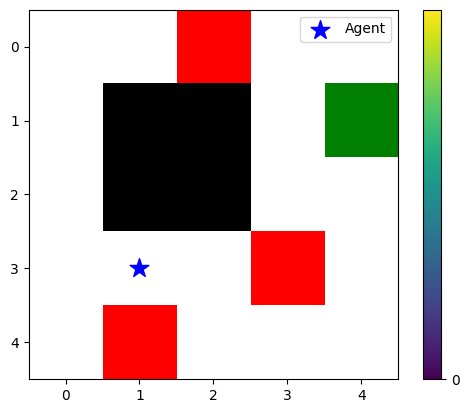

Action: 1, Next State: (3, 1), Reward: 0.0, Done: False


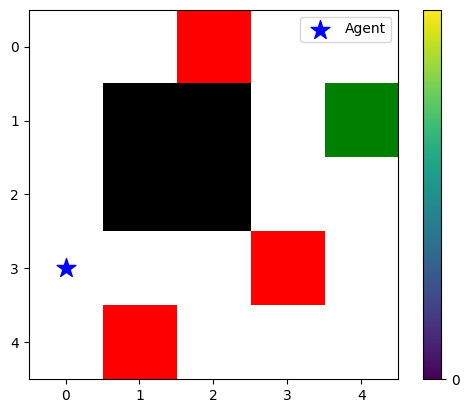

Action: 3, Next State: (3, 0), Reward: 0.0, Done: False


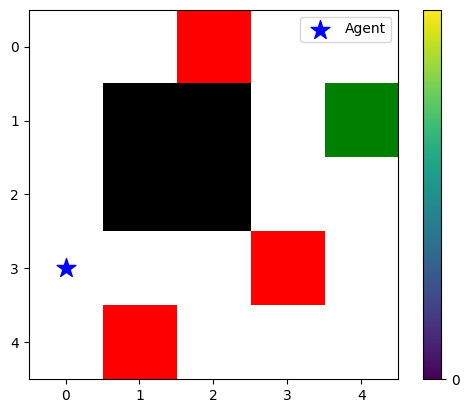

Action: 3, Next State: (3, 0), Reward: 0.0, Done: False


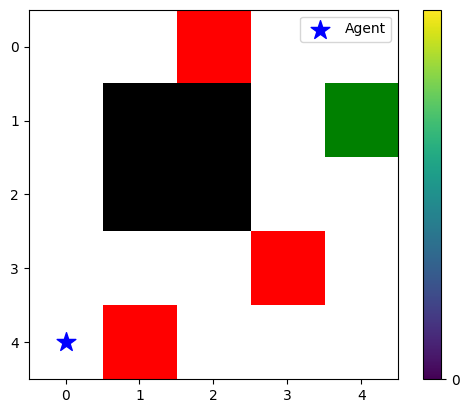

Action: 2, Next State: (4, 0), Reward: 0.0, Done: False


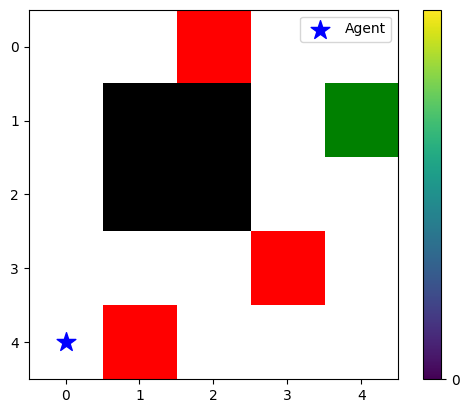

Action: 3, Next State: (4, 0), Reward: 0.0, Done: False


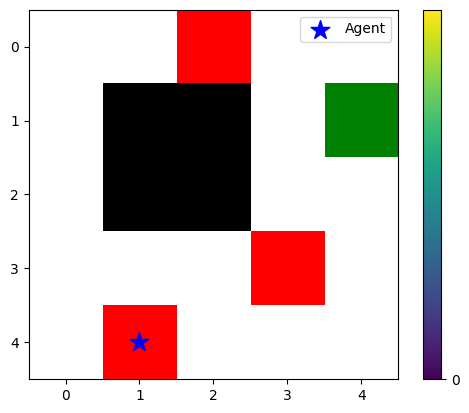

Action: 1, Next State: (4, 1), Reward: -5.0, Done: True


In [38]:
env = Grid_world_Env_Deterministic()

# Reset the environment
state = env.reset()
done = False

# Run one episode
while not done:
    action = np.random.choice([0, 1, 2, 3])  # Random action
    next_state, reward, done, info = env.step(action)
    env.render()
    print(f"Action: {action}, Next State: {next_state}, Reward: {reward}, Done: {done}")

##**II.** A linear solver to solve the system Ax = b (Deterministic case).

In [45]:
class Agent_1:
    def __init__(self, env):
        self.env = env
        self.discount_factor = 0.6 #  discount factor (Gamma)
        self.transition_matrix, self.reward_vector = self.build_system()

    def build_system(self):
        num_states = self.env.grid_size[0] * self.env.grid_size[1]
        transition_matrix = np.zeros((num_states, num_states))
        reward_vector = np.zeros(num_states)

        for s in range(num_states):
            state_coords = (s // self.env.grid_size[1], s % self.env.grid_size[1])
            if state_coords in self.env.blocked_cells:
                continue

            self.env.current_position = state_coords
            if state_coords == self.env.goal:
                reward_vector[s] = self.env.rewards[state_coords]
                continue

            for a in range(self.env.action_space.n):
                self.env.current_position = state_coords
                next_state, reward, _, _ = self.env.step(a)
                next_state_index = next_state[0] * self.env.grid_size[1] + next_state[1]

                transition_matrix[s, next_state_index] += 1 / self.env.action_space.n
                reward_vector[s] += reward / self.env.action_space.n

            # Normalize the transition probabilities to sum to 1
            row_sum = np.sum(transition_matrix[s])
            if row_sum > 0:
                transition_matrix[s] /= row_sum

            self.env.reset()

        return transition_matrix, reward_vector

    def solve_system(self):
        I = np.eye(self.transition_matrix.shape[0])
        A = I - self.discount_factor * self.transition_matrix
        b = self.reward_vector
        state_values = solve(A, b)
        state_values = state_values.reshape(self.env.grid_size)

        # Explicitly set the state values for fire cells to -5
        for cell in self.env.fire_cells:
            state_values[cell] = -5.0

        return state_values

In [46]:
# Gridworld environment
env = Grid_world_Env_Deterministic()

# The agent instance
agent = Agent_1(env)

# Perform linear solver to get state values
state_values = agent.solve_system()

print("State Values:\n", state_values)

State Values:
 [[-0.66190228 -2.89367222 -5.         -1.47964547  2.54007597]
 [-0.19520509  0.          0.          1.91716779  5.        ]
 [-0.24905479  0.          0.         -0.98973708  1.91866163]
 [-0.9670506  -2.61707556 -2.63225397 -5.         -1.47118036]
 [-2.61382305 -5.         -2.85469075 -2.31353666 -0.81101079]]


##**III.**Apply a Dynamic Programming Algorithm:Using Value Iteration Method (Deterministic Env)

In [47]:
class Agent_2:
    def __init__(self, env, gamma=0.6, theta=1e-4):
        self.env = env
        self.gamma = gamma
        self.theta = theta

    def value_iteration(self):
        V = np.zeros(self.env.grid_size)
        iteration = 0
        while True:
            delta = 0
            for x in range(self.env.grid_size[0]):
                for y in range(self.env.grid_size[1]):
                    if (x, y) in self.env.blocked_cells:
                        continue  # Skip blocked cells

                    v = V[x, y]
                    V[x, y] = max(
                        sum(p * (r + self.gamma * V[nx, ny]) for (nx, ny), p, r in self.transitions((x, y), a))
                        for a in range(self.env.action_space.n)
                    )
                    delta = max(delta, abs(v - V[x, y]))
            iteration += 1
            print(f"Value Iteration: {iteration}")
            if delta < self.theta:
                break

        # Compute the optimal policy
        optimal_policy = self.compute_optimal_policy(V)
        return optimal_policy, V, iteration

    def compute_optimal_policy(self, V):
        optimal_policy = np.zeros((self.env.grid_size[0], self.env.grid_size[1], self.env.action_space.n))
        for x in range(self.env.grid_size[0]):
            for y in range(self.env.grid_size[1]):
                if (x, y) in self.env.blocked_cells:
                    continue  # Skip blocked cells

                q_values = np.array([
                    sum(p * (r + self.gamma * V[nx, ny]) for (nx, ny), p, r in self.transitions((x, y), a))
                    for a in range(self.env.action_space.n)
                ])
                best_action = np.argmax(q_values)
                optimal_policy[x, y, best_action] = 1.0

        # Convert the optimal policy to the readable format
        return self.convert_policy_to_readable_format(optimal_policy)

    def convert_policy_to_readable_format(self, policy):
        directions = np.array(['N', 'E', 'S', 'W'])
        readable_policy = np.full((self.env.grid_size[0], self.env.grid_size[1]), '', dtype='<U1')

        for x in range(self.env.grid_size[0]):
            for y in range(self.env.grid_size[1]):
                if (x, y) in self.env.blocked_cells:
                    readable_policy[x, y] = 'X'  # Mark blocked cells
                else:
                    best_action = np.argmax(policy[x, y])
                    readable_policy[x, y] = directions[best_action]

        return readable_policy

    def transitions(self, state, action):
        transitions = []
        x, y = state
        if action == 0:  # North
            new_x, new_y = x - 1, y
        elif action == 1:  # East
            new_x, new_y = x, y + 1
        elif action == 2:  # South
            new_x, new_y = x + 1, y
        elif action == 3:  # West
            new_x, new_y = x, y - 1

        if self.env.is_valid_state(new_x, new_y):
            transitions.append(((new_x, new_y), 1.0, self.env.rewards[new_x, new_y]))
        else:
            transitions.append(((x, y), 1.0, self.env.rewards[x, y]))

        return transitions

In [48]:
# Create the environment
env = Grid_world_Env_Deterministic()
agent = Agent_2(env)

# Perform value iteration to get the optimal policy and state values
optimal_policy, state_values, iterations = agent.value_iteration()

print("Optimal Policy:\n", optimal_policy)
print("State Values:\n", state_values)
print("Number of Iterations:", iterations)

Value Iteration: 1
Value Iteration: 2
Value Iteration: 3
Value Iteration: 4
Value Iteration: 5
Value Iteration: 6
Value Iteration: 7
Value Iteration: 8
Value Iteration: 9
Value Iteration: 10
Value Iteration: 11
Value Iteration: 12
Value Iteration: 13
Value Iteration: 14
Value Iteration: 15
Value Iteration: 16
Value Iteration: 17
Value Iteration: 18
Value Iteration: 19
Value Iteration: 20
Value Iteration: 21
Value Iteration: 22
Value Iteration: 23
Optimal Policy:
 [['S' 'W' 'E' 'E' 'S']
 ['S' 'X' 'X' 'E' 'E']
 ['S' 'X' 'X' 'E' 'N']
 ['E' 'E' 'S' 'E' 'N']
 ['N' 'E' 'E' 'E' 'N']]
State Values:
 [[ 0.0755614   0.04533684  4.49990128  7.49990128 12.49990128]
 [ 0.12594988  0.          0.         12.49990128 12.49990128]
 [ 0.20993068  0.          0.          7.49994077 12.49994077]
 [ 0.34989868  0.58317868  0.97197868  4.49996446  7.49996446]
 [ 0.20993921  0.97197868  1.61997868  2.69997868  4.49997868]]
Number of Iterations: 23


##**IV.** Analyze Algorithm Convergence: (10 points)

##**a.** Examine the number of iterations your algorithm takes to converge.(Stochastic Environment)

In [58]:
class Grid_world_Env_Stochastic(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, grid_size=(5, 5), start=(0, 0), goal=(1, 4), fire_cells=[(0, 2), (3, 3), (4, 1)], blocked_cells=[(1, 1), (1, 2), (2, 1),(2,2)], noise=0.3):
        super(Grid_world_Env_Stochastic, self).__init__()

        self.grid_size = grid_size
        self.start = start
        self.goal = goal
        self.fire_cells = fire_cells
        self.blocked_cells = blocked_cells
        self.noise = noise
        self.current_position = start

        self.action_space = spaces.Discrete(4)
        # 4 actions: 0=North, 1=East, 2=South, 3=West
        self.observation_space = spaces.Tuple((spaces.Discrete(grid_size[0]), spaces.Discrete(grid_size[1])))

        self.rewards = np.zeros(grid_size)
        self.rewards[goal] = 5
        for cell in fire_cells:
            self.rewards[cell] = -5

    def reset(self):
        self.current_position = self.start
        return self.current_position

    def is_valid_state(self, x, y):
        return 0 <= x < self.grid_size[0] and 0 <= y < self.grid_size[1] and (x, y) not in self.blocked_cells

    def step(self, action):
        if np.random.rand() < self.noise:
            action = np.random.choice([0, 1, 2, 3])

        x, y = self.current_position
        if action == 0:  # North
            new_x, new_y = x - 1, y
        elif action == 1:  # East
            new_x, new_y = x, y + 1
        elif action == 2:  # South
            new_x, new_y = x + 1, y
        elif action == 3:  # West
            new_x, new_y = x, y - 1

        if not self.is_valid_state(new_x, new_y):
            new_x, new_y = x, y

        reward = self.rewards[new_x, new_y]
        done = (new_x, new_y) == self.goal or (new_x, new_y) in self.fire_cells

        self.current_position = (new_x, new_y)

        return (new_x, new_y), reward, done, {}


    def render(self, mode='human'):
        grid_copy = np.full(self.grid_size, -5)  # Initialize grid with  white

        # Mark goal, fire, and blocked cells
        grid_copy[self.goal] = 5
        for cell in self.fire_cells:
            grid_copy[cell] = 3
        for cell in self.blocked_cells:
            grid_copy[cell] = 0

        # Define a color map for the grid
        cmap = colors.ListedColormap(['white', 'black', 'red', 'green'])
        bounds = [-6, -4, 1, 4, 6]
        norm = colors.BoundaryNorm(bounds, cmap.N)

        # Plot the grid
        plt.imshow(grid_copy, cmap=cmap, norm=norm, interpolation='nearest')

        # Mark the agent's position with a different marker
        agent_x, agent_y = self.current_position
        plt.scatter(agent_y, agent_x, c='blue', s=200, marker='*', label='Agent')

        plt.colorbar(ticks=[-5, 0, 3, 5], format='%d')
        plt.legend()
        plt.show()

##**With gamma = 0.95 and theta = 1e-7**

In [50]:
class Agent_2:
    def __init__(self, env, gamma=0.95, theta=1e-7):
        self.env = env
        self.gamma = gamma
        self.theta = theta

    def value_iteration(self):
        V = np.zeros(self.env.grid_size)
        iteration = 0
        while True:
            delta = 0
            for x in range(self.env.grid_size[0]):
                for y in range(self.env.grid_size[1]):
                    if (x, y) in self.env.blocked_cells:
                        continue  # Skip blocked cells

                    v = V[x, y]
                    V[x, y] = max(
                        sum(p * (r + self.gamma * V[nx, ny]) for (nx, ny), p, r in self.transitions((x, y), a))
                        for a in range(self.env.action_space.n)
                    )
                    delta = max(delta, abs(v - V[x, y]))
            iteration += 1
            print(f"Value Iteration: {iteration}")
            if delta < self.theta:
                break

        # Compute the optimal policy
        optimal_policy = self.compute_optimal_policy(V)
        return optimal_policy, V, iteration

    def compute_optimal_policy(self, V):
        optimal_policy = np.zeros((self.env.grid_size[0], self.env.grid_size[1], self.env.action_space.n))
        for x in range(self.env.grid_size[0]):
            for y in range(self.env.grid_size[1]):
                if (x, y) in self.env.blocked_cells:
                    continue  # Skip blocked cells

                q_values = np.array([
                    sum(p * (r + self.gamma * V[nx, ny]) for (nx, ny), p, r in self.transitions((x, y), a))
                    for a in range(self.env.action_space.n)
                ])
                best_action = np.argmax(q_values)
                optimal_policy[x, y, best_action] = 1.0

        # Convert the optimal policy to the readable format
        return self.convert_policy_to_readable_format(optimal_policy)

    def convert_policy_to_readable_format(self, policy):
        directions = np.array(['N', 'E', 'S', 'W'])
        readable_policy = np.full((self.env.grid_size[0], self.env.grid_size[1]), '', dtype='<U1')

        for x in range(self.env.grid_size[0]):
            for y in range(self.env.grid_size[1]):
                if (x, y) in self.env.blocked_cells:
                    readable_policy[x, y] = 'X'  # Mark blocked cells
                else:
                    best_action = np.argmax(policy[x, y])
                    readable_policy[x, y] = directions[best_action]

        return readable_policy

    def transitions(self, state, action):
        transitions = []
        x, y = state
        if action == 0:  # North
            new_x, new_y = x - 1, y
        elif action == 1:  # East
            new_x, new_y = x, y + 1
        elif action == 2:  # South
            new_x, new_y = x + 1, y
        elif action == 3:  # West
            new_x, new_y = x, y - 1

        if self.env.is_valid_state(new_x, new_y):
            transitions.append(((new_x, new_y), 1.0, self.env.rewards[new_x, new_y]))
        else:
            transitions.append(((x, y), 1.0, self.env.rewards[x, y]))

        return transitions

In [51]:
# Create the environment
env = Grid_world_Env_Stochastic()

# Create the agent instance
agent = Agent_2(env)

# Perform value iteration to find the optimal policy and state values
optimal_policy, optimal_state_values, iterations = agent.value_iteration()

print("Optimal Policy:\n", optimal_policy)
print("Optimal State Values:\n", optimal_state_values)
print("Iterations:", iterations)

Value Iteration: 1
Value Iteration: 2
Value Iteration: 3
Value Iteration: 4
Value Iteration: 5
Value Iteration: 6
Value Iteration: 7
Value Iteration: 8
Value Iteration: 9
Value Iteration: 10
Value Iteration: 11
Value Iteration: 12
Value Iteration: 13
Value Iteration: 14
Value Iteration: 15
Value Iteration: 16
Value Iteration: 17
Value Iteration: 18
Value Iteration: 19
Value Iteration: 20
Value Iteration: 21
Value Iteration: 22
Value Iteration: 23
Value Iteration: 24
Value Iteration: 25
Value Iteration: 26
Value Iteration: 27
Value Iteration: 28
Value Iteration: 29
Value Iteration: 30
Value Iteration: 31
Value Iteration: 32
Value Iteration: 33
Value Iteration: 34
Value Iteration: 35
Value Iteration: 36
Value Iteration: 37
Value Iteration: 38
Value Iteration: 39
Value Iteration: 40
Value Iteration: 41
Value Iteration: 42
Value Iteration: 43
Value Iteration: 44
Value Iteration: 45
Value Iteration: 46
Value Iteration: 47
Value Iteration: 48
Value Iteration: 49
Value Iteration: 50
Value Ite

###**With gamma = 0.95 and theta = 1e-1 (increase theta)**

In [52]:
class Agent_2:
    def __init__(self, env, gamma=0.95, theta=1e-1):
        self.env = env
        self.gamma = gamma
        self.theta = theta

    def value_iteration(self):
        V = np.zeros(self.env.grid_size)
        iteration = 0
        while True:
            delta = 0
            for x in range(self.env.grid_size[0]):
                for y in range(self.env.grid_size[1]):
                    if (x, y) in self.env.blocked_cells:
                        continue  # Skip blocked cells

                    v = V[x, y]
                    V[x, y] = max(
                        sum(p * (r + self.gamma * V[nx, ny]) for (nx, ny), p, r in self.transitions((x, y), a))
                        for a in range(self.env.action_space.n)
                    )
                    delta = max(delta, abs(v - V[x, y]))
            iteration += 1
            print(f"Value Iteration: {iteration}")
            if delta < self.theta:
                break

        # Compute the optimal policy
        optimal_policy = self.compute_optimal_policy(V)
        return optimal_policy, V, iteration

    def compute_optimal_policy(self, V):
        optimal_policy = np.zeros((self.env.grid_size[0], self.env.grid_size[1], self.env.action_space.n))
        for x in range(self.env.grid_size[0]):
            for y in range(self.env.grid_size[1]):
                if (x, y) in self.env.blocked_cells:
                    continue  # Skip blocked cells

                q_values = np.array([
                    sum(p * (r + self.gamma * V[nx, ny]) for (nx, ny), p, r in self.transitions((x, y), a))
                    for a in range(self.env.action_space.n)
                ])
                best_action = np.argmax(q_values)
                optimal_policy[x, y, best_action] = 1.0

        # Convert the optimal policy to the readable format
        return self.convert_policy_to_readable_format(optimal_policy)

    def convert_policy_to_readable_format(self, policy):
        directions = np.array(['N', 'E', 'S', 'W'])
        readable_policy = np.full((self.env.grid_size[0], self.env.grid_size[1]), '', dtype='<U1')

        for x in range(self.env.grid_size[0]):
            for y in range(self.env.grid_size[1]):
                if (x, y) in self.env.blocked_cells:
                    readable_policy[x, y] = 'X'  # Mark blocked cells
                else:
                    best_action = np.argmax(policy[x, y])
                    readable_policy[x, y] = directions[best_action]

        return readable_policy

    def transitions(self, state, action):
        transitions = []
        x, y = state
        if action == 0:  # North
            new_x, new_y = x - 1, y
        elif action == 1:  # East
            new_x, new_y = x, y + 1
        elif action == 2:  # South
            new_x, new_y = x + 1, y
        elif action == 3:  # West
            new_x, new_y = x, y - 1

        if self.env.is_valid_state(new_x, new_y):
            transitions.append(((new_x, new_y), 1.0, self.env.rewards[new_x, new_y]))
        else:
            transitions.append(((x, y), 1.0, self.env.rewards[x, y]))

        return transitions

In [53]:
# Create the environment
env = Grid_world_Env_Stochastic()

# Create the agent instance
agent = Agent_2(env)

# Perform value iteration to find the optimal policy and state values
optimal_policy, optimal_state_values, iterations = agent.value_iteration()

print("Optimal Policy:\n", optimal_policy)
print("Optimal State Values:\n", optimal_state_values)
print("Iterations:", iterations)

Value Iteration: 1
Value Iteration: 2
Value Iteration: 3
Value Iteration: 4
Value Iteration: 5
Value Iteration: 6
Value Iteration: 7
Value Iteration: 8
Value Iteration: 9
Value Iteration: 10
Value Iteration: 11
Value Iteration: 12
Value Iteration: 13
Value Iteration: 14
Value Iteration: 15
Value Iteration: 16
Value Iteration: 17
Value Iteration: 18
Value Iteration: 19
Value Iteration: 20
Value Iteration: 21
Value Iteration: 22
Value Iteration: 23
Value Iteration: 24
Value Iteration: 25
Value Iteration: 26
Value Iteration: 27
Value Iteration: 28
Value Iteration: 29
Value Iteration: 30
Value Iteration: 31
Value Iteration: 32
Value Iteration: 33
Value Iteration: 34
Value Iteration: 35
Value Iteration: 36
Value Iteration: 37
Value Iteration: 38
Value Iteration: 39
Value Iteration: 40
Value Iteration: 41
Value Iteration: 42
Value Iteration: 43
Value Iteration: 44
Value Iteration: 45
Value Iteration: 46
Value Iteration: 47
Value Iteration: 48
Value Iteration: 49
Value Iteration: 50
Value Ite

##**With gamma = 0.75 and theta = 1e-7**

In [54]:
class Agent_2:
    def __init__(self, env, gamma=0.75, theta=1e-7):
        self.env = env
        self.gamma = gamma
        self.theta = theta

    def value_iteration(self):
        V = np.zeros(self.env.grid_size)
        iteration = 0
        while True:
            delta = 0
            for x in range(self.env.grid_size[0]):
                for y in range(self.env.grid_size[1]):
                    if (x, y) in self.env.blocked_cells:
                        continue  # Skip blocked cells

                    v = V[x, y]
                    V[x, y] = max(
                        sum(p * (r + self.gamma * V[nx, ny]) for (nx, ny), p, r in self.transitions((x, y), a))
                        for a in range(self.env.action_space.n)
                    )
                    delta = max(delta, abs(v - V[x, y]))
            iteration += 1
            print(f"Value Iteration: {iteration}")
            if delta < self.theta:
                break

        # Compute the optimal policy
        optimal_policy = self.compute_optimal_policy(V)
        return optimal_policy, V, iteration

    def compute_optimal_policy(self, V):
        optimal_policy = np.zeros((self.env.grid_size[0], self.env.grid_size[1], self.env.action_space.n))
        for x in range(self.env.grid_size[0]):
            for y in range(self.env.grid_size[1]):
                if (x, y) in self.env.blocked_cells:
                    continue  # Skip blocked cells

                q_values = np.array([
                    sum(p * (r + self.gamma * V[nx, ny]) for (nx, ny), p, r in self.transitions((x, y), a))
                    for a in range(self.env.action_space.n)
                ])
                best_action = np.argmax(q_values)
                optimal_policy[x, y, best_action] = 1.0

        # Convert the optimal policy to the readable format
        return self.convert_policy_to_readable_format(optimal_policy)

    def convert_policy_to_readable_format(self, policy):
        directions = np.array(['N', 'E', 'S', 'W'])
        readable_policy = np.full((self.env.grid_size[0], self.env.grid_size[1]), '', dtype='<U1')

        for x in range(self.env.grid_size[0]):
            for y in range(self.env.grid_size[1]):
                if (x, y) in self.env.blocked_cells:
                    readable_policy[x, y] = 'X'  # Mark blocked cells
                else:
                    best_action = np.argmax(policy[x, y])
                    readable_policy[x, y] = directions[best_action]

        return readable_policy

    def transitions(self, state, action):
        transitions = []
        x, y = state
        if action == 0:  # North
            new_x, new_y = x - 1, y
        elif action == 1:  # East
            new_x, new_y = x, y + 1
        elif action == 2:  # South
            new_x, new_y = x + 1, y
        elif action == 3:  # West
            new_x, new_y = x, y - 1

        if self.env.is_valid_state(new_x, new_y):
            transitions.append(((new_x, new_y), 1.0, self.env.rewards[new_x, new_y]))
        else:
            transitions.append(((x, y), 1.0, self.env.rewards[x, y]))

        return transitions

In [55]:
# Create the environment
env = Grid_world_Env_Stochastic()

# Create the agent instance
agent = Agent_2(env)

# Perform value iteration to find the optimal policy and state values
optimal_policy, optimal_state_values, iterations = agent.value_iteration()

print("Optimal Policy:\n", optimal_policy)
print("Optimal State Values:\n", optimal_state_values)
print("Iterations:", iterations)

Value Iteration: 1
Value Iteration: 2
Value Iteration: 3
Value Iteration: 4
Value Iteration: 5
Value Iteration: 6
Value Iteration: 7
Value Iteration: 8
Value Iteration: 9
Value Iteration: 10
Value Iteration: 11
Value Iteration: 12
Value Iteration: 13
Value Iteration: 14
Value Iteration: 15
Value Iteration: 16
Value Iteration: 17
Value Iteration: 18
Value Iteration: 19
Value Iteration: 20
Value Iteration: 21
Value Iteration: 22
Value Iteration: 23
Value Iteration: 24
Value Iteration: 25
Value Iteration: 26
Value Iteration: 27
Value Iteration: 28
Value Iteration: 29
Value Iteration: 30
Value Iteration: 31
Value Iteration: 32
Value Iteration: 33
Value Iteration: 34
Value Iteration: 35
Value Iteration: 36
Value Iteration: 37
Value Iteration: 38
Value Iteration: 39
Value Iteration: 40
Value Iteration: 41
Value Iteration: 42
Value Iteration: 43
Value Iteration: 44
Value Iteration: 45
Value Iteration: 46
Value Iteration: 47
Value Iteration: 48
Value Iteration: 49
Value Iteration: 50
Value Ite

###**With gamma = 0.75 and theta = 1e-1 (increase theta)**

In [56]:
class Agent_2:
    def __init__(self, env, gamma=0.75, theta=1e-1):
        self.env = env
        self.gamma = gamma
        self.theta = theta

    def value_iteration(self):
        V = np.zeros(self.env.grid_size)
        iteration = 0
        while True:
            delta = 0
            for x in range(self.env.grid_size[0]):
                for y in range(self.env.grid_size[1]):
                    if (x, y) in self.env.blocked_cells:
                        continue  # Skip blocked cells

                    v = V[x, y]
                    V[x, y] = max(
                        sum(p * (r + self.gamma * V[nx, ny]) for (nx, ny), p, r in self.transitions((x, y), a))
                        for a in range(self.env.action_space.n)
                    )
                    delta = max(delta, abs(v - V[x, y]))
            iteration += 1
            print(f"Value Iteration: {iteration}")
            if delta < self.theta:
                break

        # Compute the optimal policy
        optimal_policy = self.compute_optimal_policy(V)
        return optimal_policy, V, iteration

    def compute_optimal_policy(self, V):
        optimal_policy = np.zeros((self.env.grid_size[0], self.env.grid_size[1], self.env.action_space.n))
        for x in range(self.env.grid_size[0]):
            for y in range(self.env.grid_size[1]):
                if (x, y) in self.env.blocked_cells:
                    continue  # Skip blocked cells

                q_values = np.array([
                    sum(p * (r + self.gamma * V[nx, ny]) for (nx, ny), p, r in self.transitions((x, y), a))
                    for a in range(self.env.action_space.n)
                ])
                best_action = np.argmax(q_values)
                optimal_policy[x, y, best_action] = 1.0

        # Convert the optimal policy to the readable format
        return self.convert_policy_to_readable_format(optimal_policy)

    def convert_policy_to_readable_format(self, policy):
        directions = np.array(['N', 'E', 'S', 'W'])
        readable_policy = np.full((self.env.grid_size[0], self.env.grid_size[1]), '', dtype='<U1')

        for x in range(self.env.grid_size[0]):
            for y in range(self.env.grid_size[1]):
                if (x, y) in self.env.blocked_cells:
                    readable_policy[x, y] = 'X'  # Mark blocked cells
                else:
                    best_action = np.argmax(policy[x, y])
                    readable_policy[x, y] = directions[best_action]

        return readable_policy

    def transitions(self, state, action):
        transitions = []
        x, y = state
        if action == 0:  # North
            new_x, new_y = x - 1, y
        elif action == 1:  # East
            new_x, new_y = x, y + 1
        elif action == 2:  # South
            new_x, new_y = x + 1, y
        elif action == 3:  # West
            new_x, new_y = x, y - 1

        if self.env.is_valid_state(new_x, new_y):
            transitions.append(((new_x, new_y), 1.0, self.env.rewards[new_x, new_y]))
        else:
            transitions.append(((x, y), 1.0, self.env.rewards[x, y]))

        return transitions

In [57]:
# Create the environment
env = Grid_world_Env_Stochastic()

# Create the agent instance
agent = Agent_2(env)

# Perform value iteration to find the optimal policy and state values
optimal_policy, optimal_state_values, iterations = agent.value_iteration()

print("Optimal Policy:\n", optimal_policy)
print("Optimal State Values:\n", optimal_state_values)
print("Iterations:", iterations)

Value Iteration: 1
Value Iteration: 2
Value Iteration: 3
Value Iteration: 4
Value Iteration: 5
Value Iteration: 6
Value Iteration: 7
Value Iteration: 8
Value Iteration: 9
Value Iteration: 10
Value Iteration: 11
Value Iteration: 12
Value Iteration: 13
Value Iteration: 14
Value Iteration: 15
Optimal Policy:
 [['E' 'E' 'E' 'E' 'S']
 ['N' 'X' 'X' 'E' 'E']
 ['S' 'X' 'X' 'E' 'N']
 ['E' 'E' 'S' 'E' 'N']
 ['N' 'E' 'E' 'E' 'N']]
Optimal State Values:
 [[ 2.31085578  3.17023078 10.98273078 14.73273078 19.73273078]
 [ 1.73314183  0.          0.         19.73273078 19.73273078]
 [ 1.8895041   0.          0.         14.79954808 19.79954808]
 [ 2.55692353  3.44681611  4.63333955 11.09966106 14.84966106]
 [ 1.91769265  4.63333955  6.2153708   8.3247458  11.1372458 ]]
Iterations: 15


##**b.** Discuss factors affecting convergence speed and policy quality.

###Several factors influence the convergence speed and the quality of the optimal policy:

**1-Discount Factor (Gamma):**

* A higher discount factor means that future rewards are considered more significant. This can lead to more iterations to evaluate the policy, as the agent considers long-term rewards.

* A lower discount factor focuses more on immediate rewards, potentially speeding up convergence but possibly resulting in a less optimal long-term policy.

**2-Threshold (Theta):**

`The threshold for stopping policy evaluation affects how precise the value function is. A smaller theta value results in more precise value estimates but requires more iterations to converge.
A larger theta value speeds up convergence but might result in a suboptimal policy due to less accurate value estimates.`

**3-Environment Size and Complexity:**

`Larger and more complex environments with more states and actions require more iterations for both policy evaluation and improvement.
The structure of the environment (presence of obstacles, rewards distribution) also impacts the convergence speed.`

**4- Reward Structure:**

`The distribution and magnitude of rewards influence convergence. Sparse rewards might slow down the learning process, while dense and well-distributed rewards can accelerate convergence.`

##**Referances**

* [Resource 1](https://towardsdatascience.com/reinforcement-learning-implement-grid-world-from-scratch-c5963765ebff)

* [Resource 2](https://dxganta.medium.com/coding-the-gridworld-example-from-deepminds-reinforcement-learning-course-in-python-17d74335fcbc)

* [Resource 3](https://stackoverflow.com/questions/49083999/how-to-solve-reinforcement-learning-grid-world-examples-using-value-iteration)

* [Resource 4](https://medium.com/@sadeepari/beyond-the-sandbox-building-your-own-reinforcement-learning-grid-world-65dbd2a1705d)

* [Resource 5](https://cs.stanford.edu/people/karpathy/reinforcejs/gridworld_dp.html)
